In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select
from sqlalchemy import inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#Base.metadata.create_all(engine)

In [17]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables

In [19]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [28]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [30]:
all_dates = session.query(Measurement.date).all()
all_dates_list =[i[0] for i in all_dates]




# Find the most recent date in the data set.


In [33]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23',)

In [35]:
type(latest_date)

sqlalchemy.engine.row.Row

In [37]:
latest_date = latest_date[0]
latest_date

'2017-08-23'

In [39]:
type(latest_date)

str

In [41]:
latest_date = datetime.strptime(latest_date, '%Y-%m-%d').date()
type(latest_date)

datetime.date

In [43]:
from_date = latest_date - relativedelta(years=1)
from_date

datetime.date(2016, 8, 23)

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the date and precipitation scores
last_yr_prcp = session.query(Measurement.date, Measurement.prcp).filter\
(Measurement.date >= from_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_yr_prcp_df = pd.DataFrame(last_yr_prcp)
last_yr_prcp_df = last_yr_prcp_df.dropna(how='any')
last_yr_prcp_df = last_yr_prcp_df.rename(columns = {'date':'Date', 'prcp':'Precipitation'})
last_yr_prcp_df['Precipitation'].max()

6.7

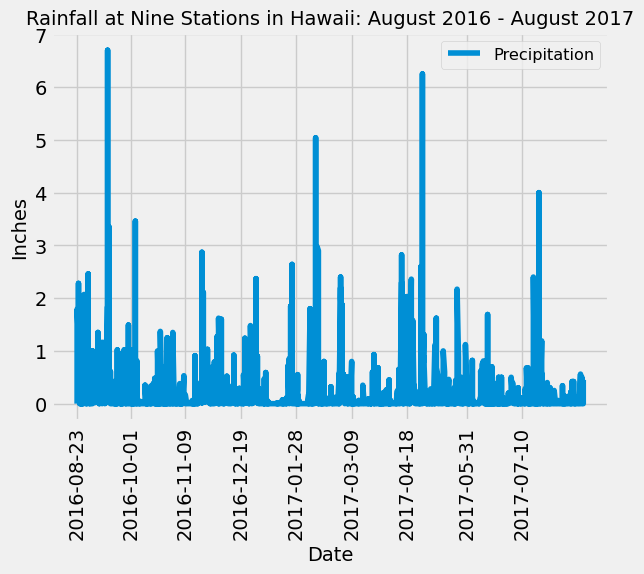

In [47]:
last_yr_prcp_sorted_df= last_yr_prcp_df.sort_values(by=["Date"], ascending=True)
x_ticks = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09','2017-04-18','2017-05-31','2017-07-10']
plt.plot(last_yr_prcp_sorted_df['Date'], last_yr_prcp_sorted_df['Precipitation'])
plt.xticks(x_ticks, fontsize=14)
plt.tick_params(axis='x', labelrotation=90)
plt.legend(['Precipitation'], loc='upper right', fontsize='small') 
plt.xlabel("Date", fontsize=14)
plt.ylabel("Inches",fontsize=14)
plt.title("Rainfall at Nine Stations in Hawaii: August 2016 - August 2017", fontsize = 14)
plt.show()

In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_yr_prcp_sorted_df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [51]:
last_yr_prcp_sorted_df['Precipitation'].median()

0.02

# Exploratory Station Analysis

In [54]:
# calculate the total number of stations in the dataset
station_count = session.execute(func.count(Station.station.distinct())).scalar()
print(f"The are {station_count} unique weather stations represented in the data")

The are 9 unique weather stations represented in the data


In [56]:
# list the stations
station_list = session.query(Station.station).all()
station_list

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [58]:
# Get the number of observations made by each station and sort
observations_by_station = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).all()
observations_by_station_sorted = sorted(observations_by_station,\
    key=lambda tupl: tupl[1], reverse=True)
observations_by_station_sorted 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
most_active_station = observations_by_station_sorted[0][0]
print(f"The most active station is {most_active_station}")

The most active station is USC00519281


In [74]:
# get the mena, min and max for temperature readings at the the most active station
most_active_station_temp_data = session.query(Measurement.tobs)\
.filter(Measurement.station == most_active_station).all()
#print(most_active_station_temp_data)
temp_list = [i[0] for i in most_active_station_temp_data]
dict = {'tobs': temp_list}
temp_df = pd.DataFrame(dict)
df = temp_df.describe()

In [80]:
mean = df.iloc[1]['tobs']
min = df.iloc[3]['tobs']
max = df.iloc[7]['tobs']

In [82]:
print(f"Average temperature at station USC00519281 is {mean:.2f} deg. F")
print(f"Maximum temperature at station USC00519281 is {max:.2f} deg F")
print(f"Minimum temperature at station USC00519281 is {min:.2f} deg F")

Average temperature at station USC00519281 is 71.66 deg. F
Maximum temperature at station USC00519281 is 85.00 deg F
Minimum temperature at station USC00519281 is 54.00 deg F


In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
last_yr_temp = session.query(Measurement.tobs).filter\
(Measurement.date >= from_date,
 Measurement.station == 'USC00519281').all()
last_yr_temp_list =[i[0] for i in last_yr_temp]
dict = {'tobs': last_yr_temp_list}
last_year_temp_df = pd.DataFrame(dict)


Text(0.5, 0, 'Temperature (deg. F.)')

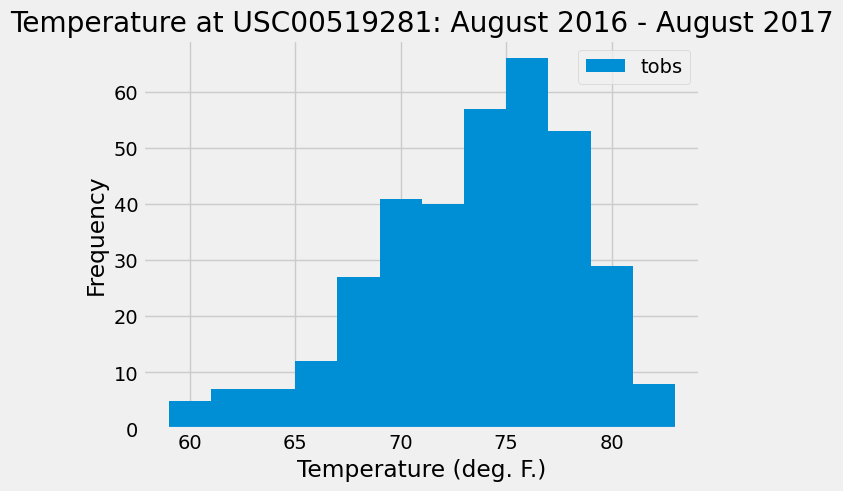

In [94]:
# plot the temperature results as a histogram for the last 12 months of most active station
last_year_temp_df.plot.hist(bins=12, title='Temperature at USC00519281: August 2016 - August 2017')
plt.xlabel('Temperature (deg. F.)')


# Close Session

In [91]:
# Close Session
session.close()